In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN.TVDNutils import *
from pyTVDN import TVDNDetect
from pyTVDN.tmpUtils import *
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict as ddict
from tqdm import tqdm
import pickle
from scipy.signal import lfilter, firls, decimate
from numpy.linalg import inv, svd
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.edgecolor"] = "0.3"
#plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams['axes.labelcolor']='black'

In [3]:
saveDir = Path("../results/fMRIHPFs_sep")
fil = list(saveDir.glob("*healthy.pkl"))[0]
print(fil)

with open(fil, "rb") as f:
    TVDNres = pickle.load(f)

../results/fMRIHPFs_sep/fMRIResultAdap_healthy.pkl


In [4]:
import rpy2.robjects as robj
robj.r.source("../Rcode/utils.R")

RsegCorr = robj.r["segCorr"]
RsegPCA = robj.r["segPCA"]
RsegDMD = robj.r["DMD"]
RchgF = robj.r["chgF"]

In [78]:
flag = 0
for DetObj in tqdm(TVDNres.DetObjs):
    time = DetObj.time
    Xmat = DetObj.Xmat
    dXmat = DetObj.dXmat
    downrate = 1
    fct = DetObj.paras.fct
    h = bw_nrd0_R(time, fct=fct)
    d, n = Xmat.shape
    Amats = []
    for s in time[::downrate]:
        t_diff = time - s
        kernels = 1/np.sqrt(2*np.pi) * np.exp(-t_diff**2/2/h**2) # normal_pdf(x/h)
        kernelroot = kernels ** (1/2)
        kerdXmat = kernelroot[:, np.newaxis] * (dXmat.T) # n x d
        kerXmat = kernelroot[:, np.newaxis] * (Xmat.T) # n x d
        M = kerXmat.T.dot(kerXmat)/n
        XY = kerdXmat.T.dot(kerXmat)/n
        U, S, VT = svd(M)
        r = np.argmax(np.cumsum(S)/np.sum(S) >= 0.999) + 1 # For real data
        invM = U[:, :r].dot(np.diag(1/S[:r])).dot(VT[:r, :])
        Amat =  XY.dot(invM)
        Amats.append(Amat)
    

    with open(f"../NeuroImgR1/fMRI_Amatss/fMRI_Amats_idx{flag}.pkl", "wb") as f:
        pickle.dump(Amats, f)
    flag += 1


100%|██████████| 103/103 [00:47<00:00,  2.20it/s]

In [5]:
Nrep = 100
errsH0s = []
errH11s = []
errH12s = []
for DetObj in tqdm(TVDNres.DetObjs):
    dXmat = DetObj.dXmat
    Xmat = DetObj.Xmat
    Ymat = DetObj.nYmat
    d, n = Ymat.shape
    ecpts = DetObj.ecpts
    ndXmat = DetObj.midRes.ndXmat
    nXmat = DetObj.midRes.nXmat
    eigVecs = DetObj.midRes.eigVecs
    r = DetObj.paras.r
    tStep = np.diff(DetObj.time)[0]
    paras = DetObj.paras
    time = DetObj.time
    predIdxs = np.delete(np.arange(n), trainIdxFn(ecpts, n))
    
    errsH0 = []
    for jj in range(Nrep):
        YmatPred = ReconXmatSWHalfH0(ecpts, dXmat, Xmat, Ymat, time, rate=0.8, is_full=True)
        YmatPred = YmatPred.EstXmatRealOrg
        diffPred = Ymat - YmatPred
                
        YPart = Ymat[:, predIdxs]
        YpredPart = YmatPred[:, predIdxs]
        pdiff = YPart - YpredPart
        # error under non random 
        err = np.sqrt((pdiff**2).sum(axis=0)/(YPart**2).sum(axis=0)).mean()
        errsH0.append(err)
        
    errsH0s.append(errsH0)
    
    YmatPred = ReconXmatSWHalf(ecpts, dXmat, Xmat, Ymat, DetObj.time, paras, is_full=True)
    YmatPred = YmatPred.EstXmatRealOrg
    diffPred = Ymat - YmatPred
            
    YPart = Ymat[:, predIdxs]
    YpredPart = YmatPred[:, predIdxs]
    pdiff = YPart - YpredPart
    errH11 = np.sqrt((pdiff**2).sum(axis=0)/(YPart**2).sum(axis=0)).mean()
    errH11s.append(errH11)
    
    
    YmatPred = ReconXmatSWHalf2(ecpts, dXmat, Xmat, Ymat, DetObj.time, rate=0.8, is_full=True)
    YmatPred = YmatPred.EstXmatRealOrg
    diffPred = Ymat - YmatPred
            
    YPart = Ymat[:, predIdxs]
    YpredPart = YmatPred[:, predIdxs]
    pdiff = YPart - YpredPart
    errH12 = np.sqrt((pdiff**2).sum(axis=0)/(YPart**2).sum(axis=0)).mean()
    errH12s.append(errH12)

100%|██████████| 103/103 [11:15<00:00,  5.12s/it]


In [6]:
pVal1s = []
pVal2s = []
for errH11, errH12, errsH0 in zip(errH11s, errH12s, errsH0s):
    pVal1 = np.mean(np.array(errsH0) <= errH11)
    pVal2 = np.mean(np.array(errsH0) <= errH12)
    pVal1s.append(pVal1)
    pVal2s.append(pVal2)

Text(0.5, 1.0, 'Method 2 (Amat)')

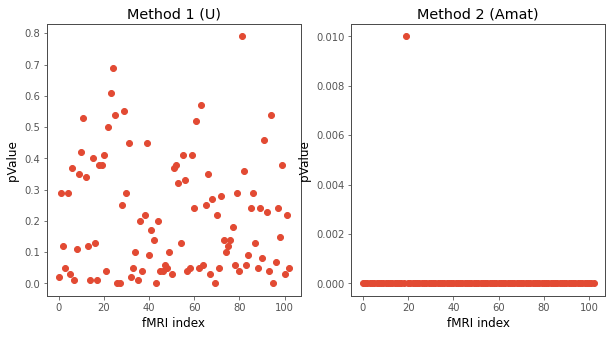

In [7]:
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.plot(pVal1s, "o")
plt.xlabel("fMRI index")
plt.ylabel("pValue ")
plt.title("Method 1 (U)")

plt.subplot(122)
plt.plot(pVal2s, "o")
plt.xlabel("fMRI index")
plt.ylabel("pValue ")
plt.title("Method 2 (Amat)")

In [9]:
np.mean(np.array(pVal1s))

0.2120388349514563

---

In [247]:
def ReconXmatSWHalf2(ecpts, dXmat, Xmat, Ymat, time, is_full=False):
    """
    Input: 
        ecpts: Estimated change points, 
        dXmat: a d x n matrix
        Xmat: a d x n matrix
        Ymat: The matrix to construct, d x n 
        time: The time seq
        r: The rank setted beforehand, in most cases, r=rAct. If we have non-complex singular values, r < rAct
        if_full: Where outputing full info or not

    Return:
        Estimated Xmat, d x n
    """
    
    d, n = Ymat.shape
    tStep = np.diff(time)[0]
    trainIdxs = trainIdxFn(ecpts, n)
    
    ecptsfull = np.concatenate(([0], ecpts, [n])) - 1
    ecptsfull = ecptsfull.astype(np.int)
    numchgfull = len(ecptsfull)

    Amats = []
    for itr in range(numchgfull-1):
        lower = ecptsfull[itr] + 1
        upper = ecptsfull[itr+1] + 1
        hncol = int(upper-lower/2)
        Ycur = dXmat[:, lower:(lower+hncol)]
        Xcur = Xmat[:, lower:(lower+hncol)]
        Amat = GetAmatNoKernel(Ycur, Xcur) 
        Amats.append(Amat)
        
    
    EstXmat = np.zeros((d, n), dtype=np.complex)
    EstXmat[:, 0] = Ymat[:, 0]
    for i in range(1, n):
        if i in trainIdxs:
            EstXmat[:, i] = Ymat[:, i]
        else:
            matIdx = np.sum(i>ecptsfull) - 1
            Amat = Amats[matIdx]
            EstXmat[:, i] = Amat.dot(EstXmat[:, i-1]) * tStep + EstXmat[:,i-1]
        
    if is_full:
        ReDict = edict()
        ReDict.EstXmatReal = detrend(EstXmat.real)
        ReDict.EstXmatRealOrg = EstXmat.real
        ReDict.EstXmatImag = EstXmat.imag
        ReDict.Amats = Amats
        return ReDict
    else:
        return detrend(EstXmat.real)

In [246]:
def ReconXmatSWHalfH0(ecpts, dXmat, Xmat, Ymat, time, is_full=False):
    """
    Input: 
        ecpts: Estimated change points, 
        dXmat: a d x n matrix
        Xmat: a d x n matrix
        Ymat: The matrix to construct, d x n 
        time: The time seq
        r: The rank setted beforehand, in most cases, r=rAct. If we have non-complex singular values, r < rAct
        if_full: Where outputing full info or not

    Return:
        Estimated Xmat, d x n
    """
    
    d, n = Ymat.shape
    tStep = np.diff(time)[0]
    trainIdxs = trainIdxFn(ecpts, n)
    
    ecptsfull = np.concatenate(([0], ecpts, [n])) - 1
    ecptsfull = ecptsfull.astype(np.int)
    numchgfull = len(ecptsfull)

    Amats = []
    for itr in range(numchgfull-1):
        lower = ecptsfull[itr] + 1
        upper = ecptsfull[itr+1] + 1
        hncol = int(upper-lower/2)
        curIdxs = np.sort(np.random.choice(trainIdxs, size=hncol, replace=1))
        curIdxs = np.array(curIdxs, dtype=int)
        Ycur = dXmat[:, curIdxs]
        Xcur = Xmat[:, curIdxs]
        Amat = GetAmatNoKernel(Ycur, Xcur) 
        Amats.append(Amat)
        
    
    EstXmat = np.zeros((d, n), dtype=np.complex)
    EstXmat[:, 0] = Ymat[:, 0]
    for i in range(1, n):
        if i in trainIdxs:
            EstXmat[:, i] = Ymat[:, i]
        else:
            matIdx = np.sum(i>ecptsfull) - 1
            Amat = Amats[matIdx]
            EstXmat[:, i] = Amat.dot(EstXmat[:, i-1]) * tStep + EstXmat[:,i-1]
        
    if is_full:
        ReDict = edict()
        ReDict.EstXmatReal = detrend(EstXmat.real)
        ReDict.EstXmatRealOrg = EstXmat.real
        ReDict.EstXmatImag = EstXmat.imag
        ReDict.Amats = Amats
        return ReDict
    else:
        return detrend(EstXmat.real)

In [255]:
def ReconXmatSWHalfH0(ecpts, dXmat, Xmat, Ymat, time, is_full=False):
    """
    Under the null: no change point to reconstruct the seqs
    Input: 
        ecpts: Estimated change points, 
        dXmat: a d x n matrix
        Xmat: a d x n matrix
        Ymat: The matrix to construct, d x n 
        time: The time step
        if_full: Where outputing full info or not

    Return:
        Estimated Xmat, d x n
    """
    #print(f"The class calls the new reconstruction function, ReconXmatNew")
    d, n = Ymat.shape
    tStep = np.diff(time)[0]
    trainIdxs = trainIdxFn(ecpts, n)
    numSps = int(len(trainIdxs))
    #numSps = int(np.max(np.diff(ecpts)))
    curIdxs = np.sort(np.random.choice(trainIdxs, size=numSps, replace=1))
    curIdxs = np.array(curIdxs, dtype=int)

    XmatPart = Xmat[:, curIdxs]
    dXmatPart = dXmat[:, curIdxs]
    timePart = time[curIdxs]
    Amat = GetAmatNoKernel(dXmatPart, XmatPart)
    
    EstXmat = np.zeros((d, n), dtype=np.complex)
    EstXmat[:, 0] = Ymat[:, 0]
    for i in range(1, n):
        if i in trainIdxs:
            EstXmat[:, i] = Ymat[:, i]
        else:
            EstXmat[:, i] = Amat.dot(EstXmat[:, i-1]) * tStep + EstXmat[:,i-1]
        
    if is_full:
        ReDict = edict()
        ReDict.EstXmatReal = detrend(EstXmat.real)
        ReDict.EstXmatRealOrg = EstXmat.real
        ReDict.EstXmatImag = EstXmat.imag
        ReDict.Amat = Amat
        return ReDict
    else:
        return detrend(EstXmat.real)

In [184]:
def GetAmatNoKernel(dXmat, Xmat):
    """
    simply linear regression to estimate Amat under H0: no change
    Input: 
        dXmat: The first derivative of Xmat, d x n matrix
        Xmat: Xmat, d x n matrix
    Return:
        A d x d matrix, it is sum of n/downrate  Ai matrix
    """
    d, n = Xmat.shape
    Amat = np.zeros((d, d))
    M = Xmat.dot(Xmat.T)/n
    XY = dXmat.dot(Xmat.T)/n
    U, S, VT = svd(M)
    r = np.argmax(np.cumsum(S)/np.sum(S) >= 0.999) # For real data
    invM = U[:, :r].dot(np.diag(1/S[:r])).dot(VT[:r, :])
    Amat = XY.dot(invM)
    Amat = lowRAmatFn(Amat, rate=0.8)
    return Amat

In [185]:
def lowRAmatFn(Amat, rate=0.8):
    eigVals, eigVecs = np.linalg.eig(Amat)
    eigVecsInv = np.linalg.inv(eigVecs)
    rSel = np.where(np.cumsum(np.abs(eigVals))/np.sum(np.abs(eigVals)) >rate)[0][0] + 1
    v1, v2 = np.abs(eigVals[rSel-1]), np.abs(eigVals[rSel])
    if np.abs(v1-v2) < 1e-10:
        rSel = rSel + 1
    lowRAmat = eigVecs[:, :rSel].dot(np.diag(eigVals[:rSel])).dot(eigVecsInv[:rSel, :])
    return lowRAmat.real